In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
import numpy as np

In [74]:
def get_model(input_shape = (128,128,3)):
    inputs = tf.keras.Input(shape=(input_shape))
    
    conv1 = Conv2D(16, 3, padding = 'same')(inputs)
    conv1 = LeakyReLU(0.01)(conv1)
    conv1 = Conv2D(16, 3, padding = 'same')(conv1)
    conv1 = LeakyReLU(0.01)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(32, 3, padding = 'same')(pool1)
    conv2 = LeakyReLU(0.01)(conv2)
    conv2 = Conv2D(32, 3, padding = 'same')(conv2)
    conv2 = LeakyReLU(0.01)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(64, 3, padding = 'same')(pool2)
    conv3 = LeakyReLU(0.01)(conv3)
    conv3 = Conv2D(64, 3, padding = 'same')(conv3)
    conv3 = LeakyReLU(0.01)(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(128, 3, padding = 'same')(pool3)
    conv4 = LeakyReLU(0.01)(conv4)
    conv4 = Conv2D(128, 3, padding = 'same')(conv4)
    conv4 = LeakyReLU(0.01)(conv4)
    
    up1 = Conv2DTranspose(64, 3, strides=2, padding = 'same')(conv4)
    up1 = LeakyReLU(0.01)(up1)
    merge1 = concatenate([conv3, up1], axis = 3)
    convUp1 = Conv2D(64, 3, padding = 'same')(merge1)
    convUp1 = LeakyReLU(0.01)(convUp1)
    convUp1 = Conv2D(64, 3, padding = 'same')(convUp1)
    convUp1 = LeakyReLU(0.01)(convUp1)
    
    up2 = Conv2DTranspose(32, 3, strides=2, padding = 'same')(convUp1)
    up2 = LeakyReLU(0.01)(up2)
    merge2 = concatenate([conv2, up2], axis = 3)
    convUp2 = Conv2D(32, 3, padding = 'same')(merge2)
    convUp2 = LeakyReLU(0.01)(convUp2)
    convUp2 = Conv2D(32, 3, padding = 'same')(convUp2)
    convUp2 = LeakyReLU(0.01)(convUp2)
    
    up3 = Conv2DTranspose(16, 3, strides=2, padding = 'same')(convUp2)
    up3 = LeakyReLU(0.01)(up3)
    merge3 = concatenate([conv1, up3], axis = 3)
    convUp3 = Conv2D(16, 3, padding = 'same')(merge3)
    convUp3 = LeakyReLU(0.01)(convUp3)
    convUp3 = Conv2D(16, 3, padding = 'same')(convUp3)
    convUp3 = LeakyReLU(0.01)(convUp3)
    
    up4 = Conv2DTranspose(16, 3, strides=2, padding = 'same')(convUp3)
    convUp4 = Conv2D(16, 3, padding = 'same')(up4)
    convUp4 = LeakyReLU(0.01)(convUp4)
    convUp4 = Conv2D(32, 3, padding = 'same')(convUp4)
    convUp4 = LeakyReLU(0.01)(convUp4)
    
    outs = Conv2D(3, 1,activation=sigmoid)(convUp4)
    
    model = tf.keras.Model(inputs = inputs, outputs = outs)
    return model

In [75]:
model = get_model()

In [76]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_36 (LeakyReLU)      (None, 128, 128, 16) 0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 16) 2320        leaky_re_lu_36[0][0]             
____________________________________________________________________________________________

In [77]:
im_shape = (128,128)
im_shape_final = (256,256)
def generate_mask(percent_masked = 0.9, shape = im_shape):
    num_elements = np.ones(shape).size
    num_masked = int(num_elements*percent_masked)
    mask_indices = np.random.choice(num_elements, num_masked, replace=False)
    mask = np.ones((num_elements))
    mask[mask_indices]=0
    mask = np.reshape(mask,(shape[0],shape[1],1))
    mask = np.concatenate([mask,mask,mask],axis = 2)
    return mask.astype(int)

In [78]:
import os
from PIL import Image
train_path = 'C:/Users/jvona/Documents/train2017'

def load_data(ids):
    X = []
    Y = []
    
    for i in ids:
        y = Image.open(os.path.join(train_path, i))
        x = np.array(y.resize(im_shape))/255.0
        y = np.array(y.resize(im_shape_final))/255.0
        if len(y.shape)<3:
            y = np.expand_dims(y,2)
            y = np.concatenate([y,y,y],axis=2)
            
            x = np.expand_dims(x,2)
            x = np.concatenate([x,x,x],axis=2)
            
        #mask = generate_mask()
        #x = y*mask
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

def batch_generator(ids, batch_size = 8):
    batch = []
    while True:
        np.random.shuffle(ids)
        for i in ids:
            batch.append(i)
            if len(batch)==batch_size:
                yield load_data(batch)
                batch = []

In [79]:
HUBER_DELTA = 0.5
def smoothL1(y_true, y_pred):
    x   = tf.keras.backend.abs(y_true - y_pred)
    x   = tf.keras.backend.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return  tf.keras.backend.sum(x)

model.compile(optimizer=Adam(1e-4),loss = smoothL1)

In [80]:
train_names = os.listdir(train_path)
batch_num = 8

In [81]:

model.fit(batch_generator(ids=train_names,batch_size=batch_num),epochs = 1,steps_per_epoch=len(train_names)//batch_num)

  ...
    to  
  ['...']
Train for 14785 steps
14785/14785 [==============================] - 170624s 12s/step - loss: 2911.5172


In [83]:
im = Image.open('C:/Users/jvona/Documents/test2017/000000000019.jpg')

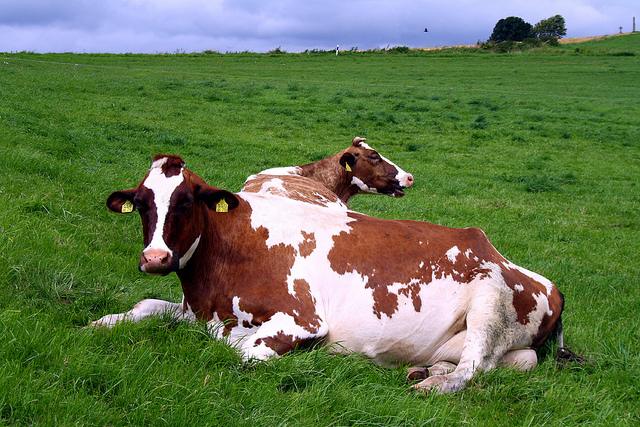

In [84]:
im

In [102]:
im_fixed = np.array(im.resize(im_shape))/255.0
#
#mask = generate_mask()
#im_masked = im_fixed*mask

In [107]:
im_fixed = (im_fixed*255).astype(np.uint8)
im_fixed = Image.fromarray(im_fixed)

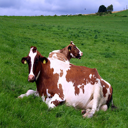

In [108]:
im_fixed

In [103]:
predicted = model.predict(np.reshape(im_fixed,(1,128,128,3)))
#predicted = np.clip(predicted,0.,1.)
predicted = predicted.squeeze()

In [104]:
predictedUL = predicted[:128,:128,:]
predictedBL = predicted[128:,:128,:]
predictedUR = predicted[:128,128:,:]
predictedBR = predicted[128:,128:,:]
newPredicted = np.zeros((512,512,3))
newPredicted[:256,:256,:] = model.predict(np.reshape(predictedUL,(1,128,128,3)))
newPredicted[256:,:256,:] = model.predict(np.reshape(predictedBL,(1,128,128,3)))
newPredicted[:256,256:,:] = model.predict(np.reshape(predictedUR,(1,128,128,3)))
newPredicted[256:,256:,:] = model.predict(np.reshape(predictedBR,(1,128,128,3)))
#predicted = np.clip(predicted,0.,1.)
newPredicted = newPredicted.squeeze()

In [105]:
new_predicted_fixed = (255*newPredicted).astype(np.uint8)
new_predicted_fixed = Image.fromarray(new_predicted_fixed)

In [97]:
predicted_fixed = (255*predicted).astype(np.uint8)
predicted_fixed = Image.fromarray(predicted_fixed)

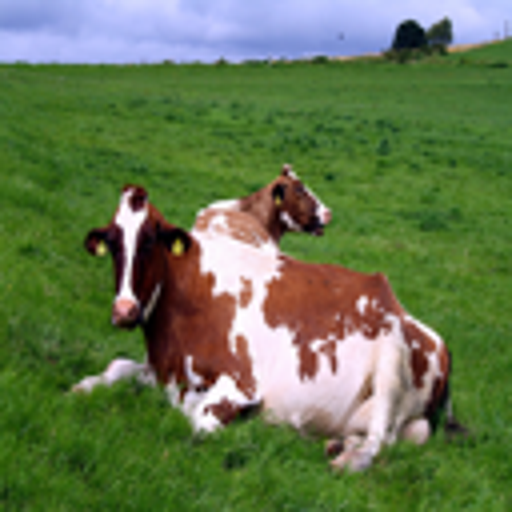

In [109]:
im_fixed.resize((512,512))

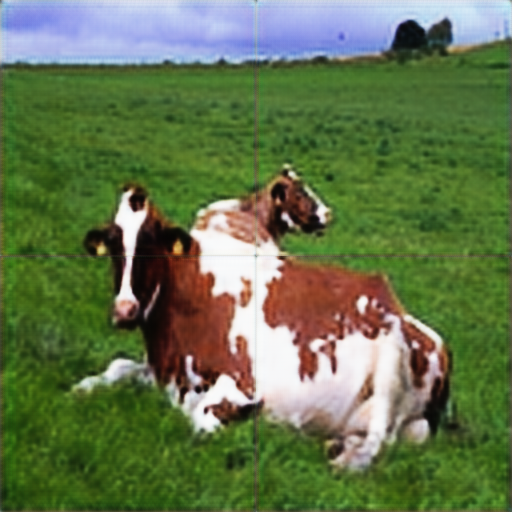

In [106]:
new_predicted_fixed

In [111]:
from PIL import ImageFilter

In [116]:
im_blurred = new_predicted_fixed.filter(filter=ImageFilter.GaussianBlur)

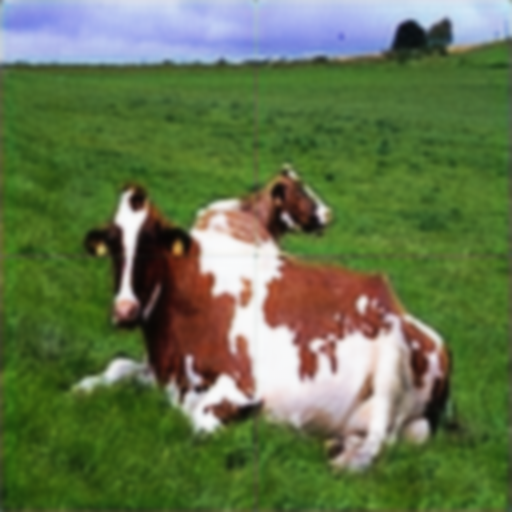

In [117]:
im_blurred